In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from transformers import AutoTokenizer, DataCollatorWithPadding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
file_path = '/content/mtsamples.csv'
df = pd.read_csv(file_path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


In [ ]:
df.head()

Unnamed: 0                                        description  \
0           0   A 23-year-old white female presents with comp...   
1           1           Consult for laparoscopic gastric bypass.   
2           2           Consult for laparoscopic gastric bypass.   
3           3                             2-D M-Mode. Doppler.     
4           4                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                       transcription  \
0  SUBJECTIVE:,  This 23-year-old white female pr...   
1  PAST MEDICAL HISTORY:, He has difficulty climb...   
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...   
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...   
4  1.  The left ventricular cavity size and wall ...   

                                            keywords  
0  allergy / immunology, allergic rhinitis, aller...  
1  bariatrics, laparoscopic gastric bypass, weigh...  
2  bariatrics, laparoscopic gastric bypass, heart...  
3  cardiovascular / pulmonary, 2-d m-mode, dopple...  
4  cardiovascular / pulmonary, 2-d, doppler, echo...

In [ ]:
unique_classes = df['medical_specialty'].nunique()

In [ ]:
top_specialties = df['medical_specialty'].value_counts().head(5)

In [ ]:
bottom_specialties = df['medical_specialty'].value_counts().tail(5)

In [ ]:
df['transcript_length_raw'] = df['transcription'].astype(str).apply(lambda x: len(x.split()) if x else 0)
length_stats = df['transcript_length_raw'].describe()

In [ ]:
eda_summary = {
    "Total Samples": len(df),
    "Unique Medical Specialties": unique_classes,
    "Top 5 Specialties": top_specialties.to_dict(),
    "Bottom 5 Specialties": bottom_specialties.to_dict(),
    "Transcription Length Stats": length_stats.to_dict()
}

In [ ]:
eda_summary

{'Total Samples': 4999,
 'Unique Medical Specialties': 40,
 'Top 5 Specialties': {' Surgery': 1103,
  ' Consult - History and Phy.': 516,
  ' Cardiovascular / Pulmonary': 372,
  ' Orthopedic': 355,
  ' Radiology': 273},
 'Bottom 5 Specialties': {' Speech - Language': 9,
  ' Autopsy': 8,
  ' Lab Medicine - Pathology': 8,
  ' Allergy / Immunology': 7,
  ' Hospice - Palliative Care': 6},
 'Transcription Length Stats': {'count': 4999.0,
  'mean': 462.38287657531504,
  'std': 317.5756035032016,
  'min': 1.0,
  '25%': 239.0,
  '50%': 397.0,
  '75%': 614.0,
  'max': 3029.0}}

In [ ]:
df['transcript_length'] = df['transcription'].astype(str).apply(lambda x: len(x.split()) if x else 0)

In [ ]:
!pip install seaborn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-14-dec63e84ae82>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


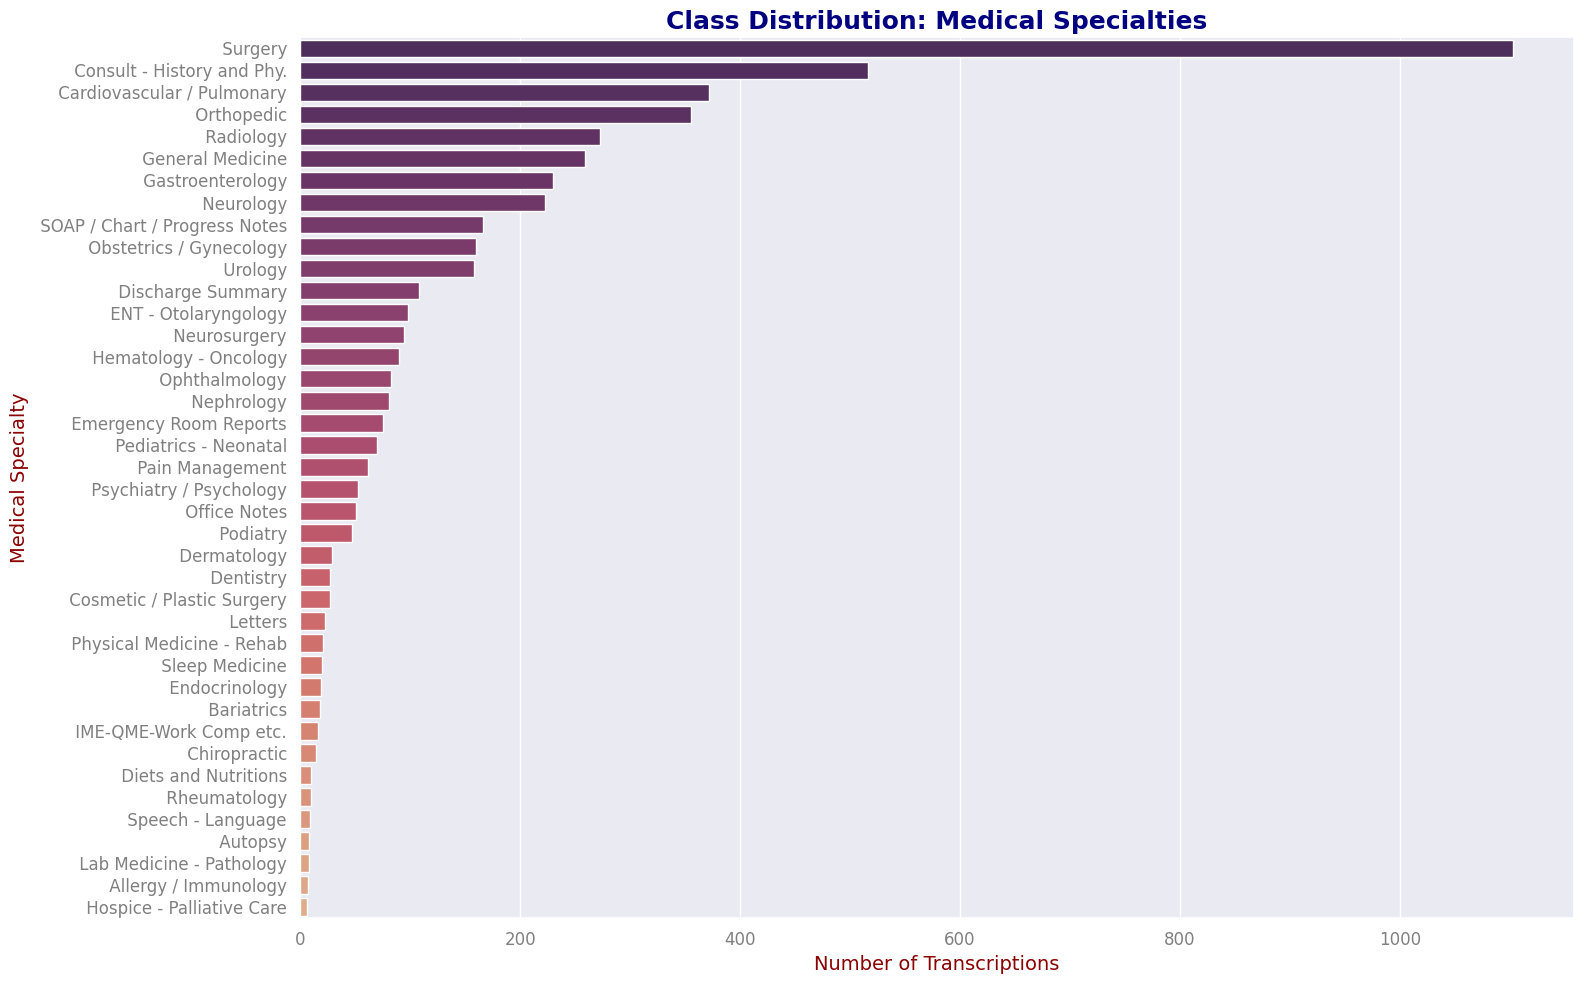

In [ ]:
plt.figure(figsize=(16, 10))
sns.set_theme(style="darkgrid", palette="rocket")

ax = sns.countplot(
    data=df,
    y='medical_specialty',
    order=df['medical_specialty'].value_counts().index,
    palette="flare_r"
)
ax.set_title("Class Distribution: Medical Specialties", fontsize=18, fontweight='bold', color='navy')
ax.set_xlabel("Number of Transcriptions", fontsize=14, color='darkred')
ax.set_ylabel("Medical Specialty", fontsize=14, color='darkred')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

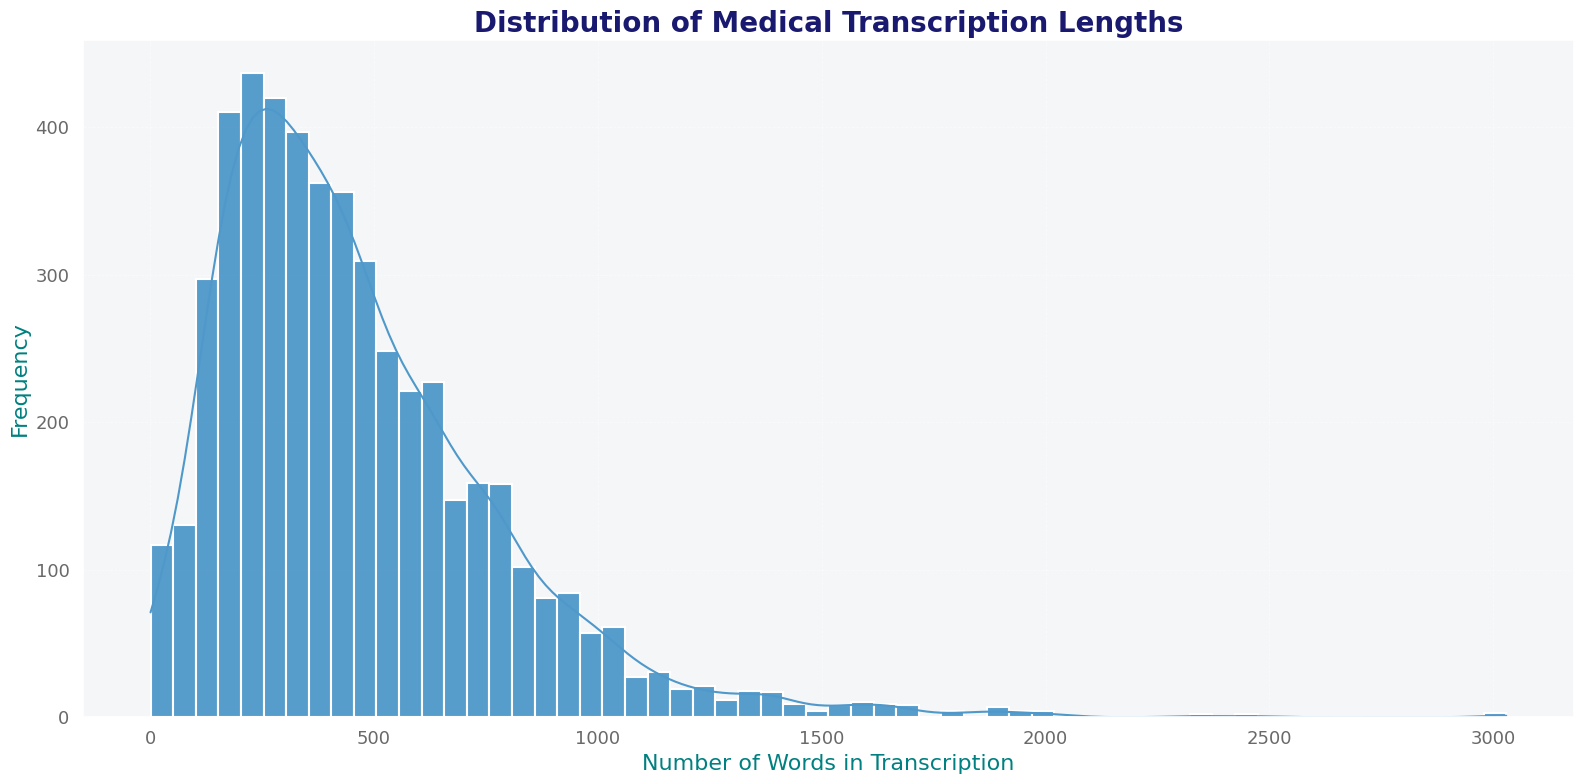

In [ ]:
plt.figure(figsize=(16, 8))
sns.set_theme(style="darkgrid")

# Color gradient + advanced aesthetic
ax = sns.histplot(
    df['transcript_length_raw'],
    bins=60,
    kde=True,
    color="#4F98CA",
    edgecolor="white",
    alpha=0.95,
    linewidth=1.5
)

# Styling and annotations
ax.set_title("Distribution of Medical Transcription Lengths", fontsize=20, fontweight='bold', color='midnightblue')
ax.set_xlabel("Number of Words in Transcription", fontsize=16, color='teal')
ax.set_ylabel("Frequency", fontsize=16, color='teal')
plt.xticks(fontsize=13, color='dimgray')
plt.yticks(fontsize=13, color='dimgray')

# Enhanced grid
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.5)

# Background color
ax.set_facecolor('#F4F6F7')
plt.tight_layout()
plt.show()

In [ ]:
df['Word Count'] = df['transcription'].astype(str).apply(lambda x: len(x.split()))

In [ ]:
top_classes = df['medical_specialty'].value_counts().head(10).index
filtered_df = df[df['medical_specialty'].isin(top_classes)]

<ipython-input-18-cd39b2765bca>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='Word Count', y='medical_specialty', palette="coolwarm")


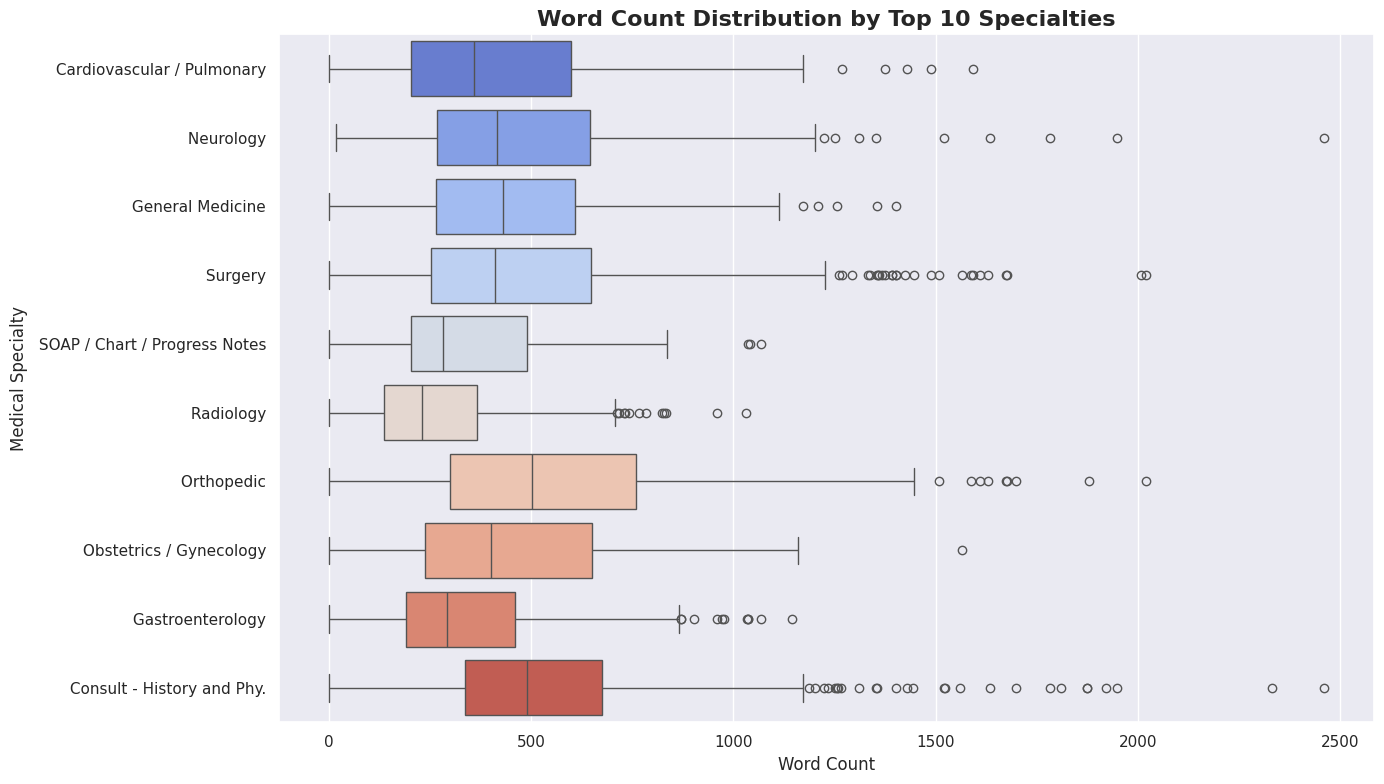

In [ ]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_df, x='Word Count', y='medical_specialty', palette="coolwarm")
plt.title("Word Count Distribution by Top 10 Specialties", fontsize=16, weight='bold')
plt.xlabel("Word Count")
plt.ylabel("Medical Specialty")
plt.tight_layout()
plt.show()

In [ ]:
!pip install WordCloud

In [ ]:
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

<ipython-input-21-b16c7eee19b8>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq, y=words, palette="crest")


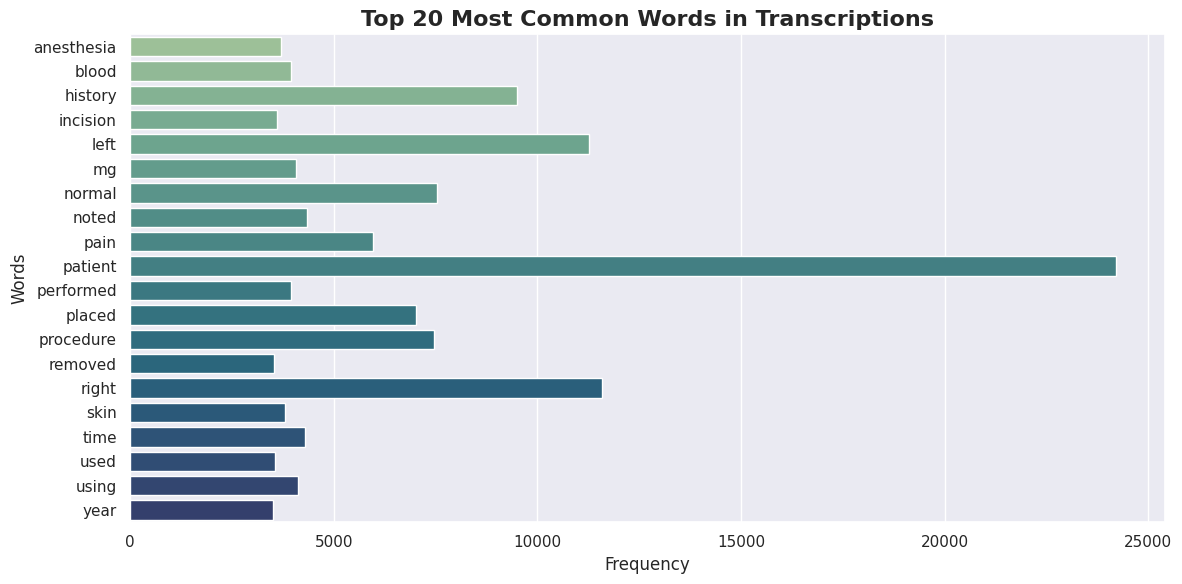

In [ ]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['transcription'].astype(str))
word_freq = X.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()

plt.figure(figsize=(12, 6))
sns.barplot(x=word_freq, y=words, palette="crest")
plt.title("Top 20 Most Common Words in Transcriptions", fontsize=16, weight='bold')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.tight_layout()
plt.show()

<ipython-input-22-e5f78bcf5821>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_freq, y=bigrams, palette="flare")


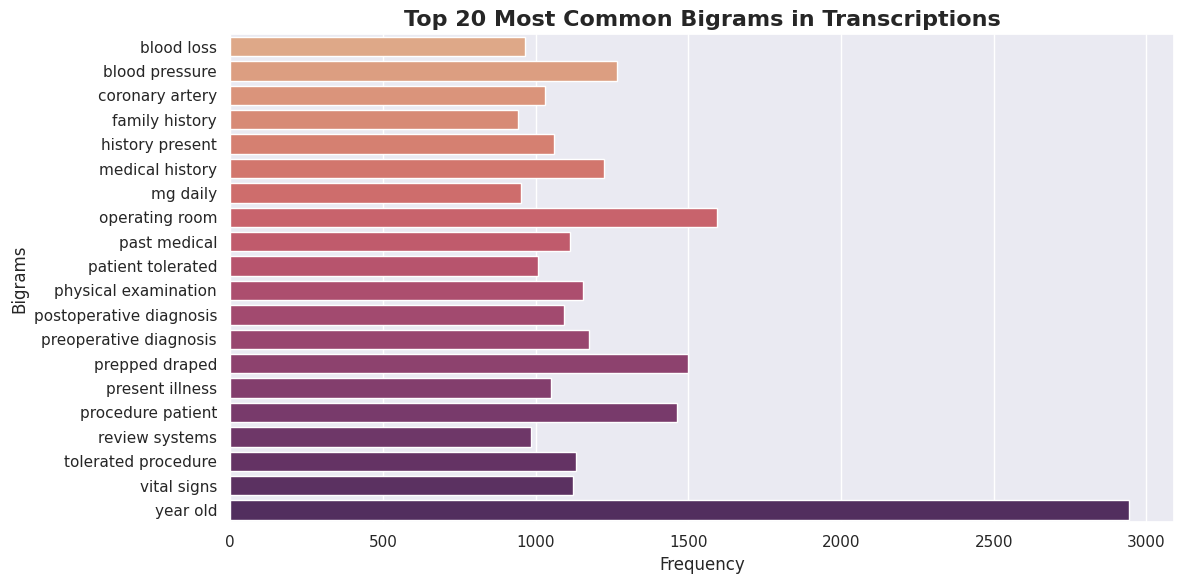

In [ ]:
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
X_bi = bigram_vectorizer.fit_transform(df['transcription'].astype(str))
bigram_freq = X_bi.toarray().sum(axis=0)
bigrams = bigram_vectorizer.get_feature_names_out()

plt.figure(figsize=(12, 6))
sns.barplot(x=bigram_freq, y=bigrams, palette="flare")
plt.title("Top 20 Most Common Bigrams in Transcriptions", fontsize=16, weight='bold')
plt.xlabel("Frequency")
plt.ylabel("Bigrams")
plt.tight_layout()
plt.show()

In [ ]:
from wordcloud import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

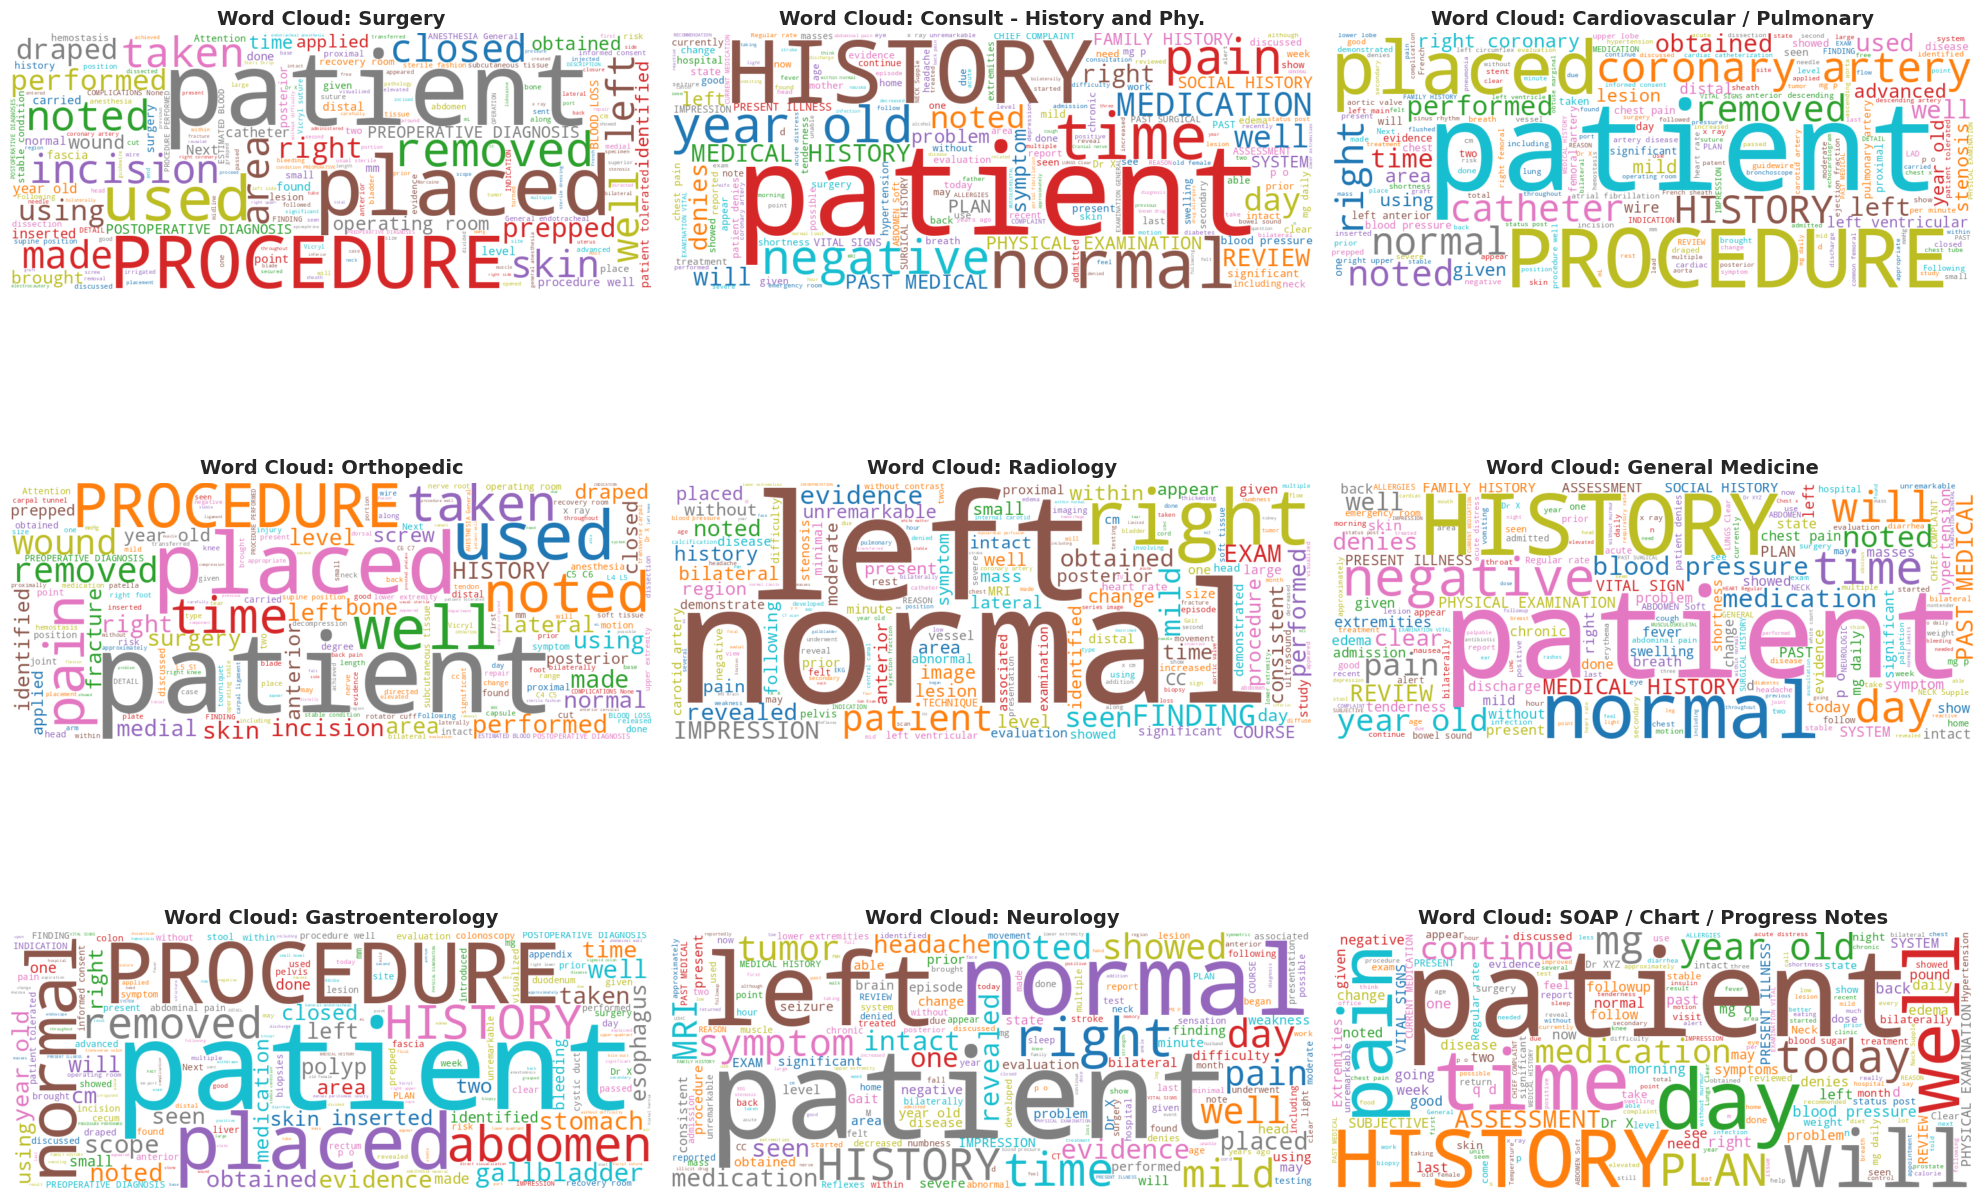

In [ ]:
top_specialties = df['medical_specialty'].value_counts().head(9).index.tolist()
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for ax, specialty in zip(axes.flatten(), top_specialties):
    text = " ".join(df[df['medical_specialty'] == specialty]['transcription'].astype(str))
    wc = WordCloud(stopwords=STOPWORDS, background_color='white', colormap='tab10', width=1000, height=400).generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"Word Cloud: {specialty.strip()}", fontsize=14, weight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

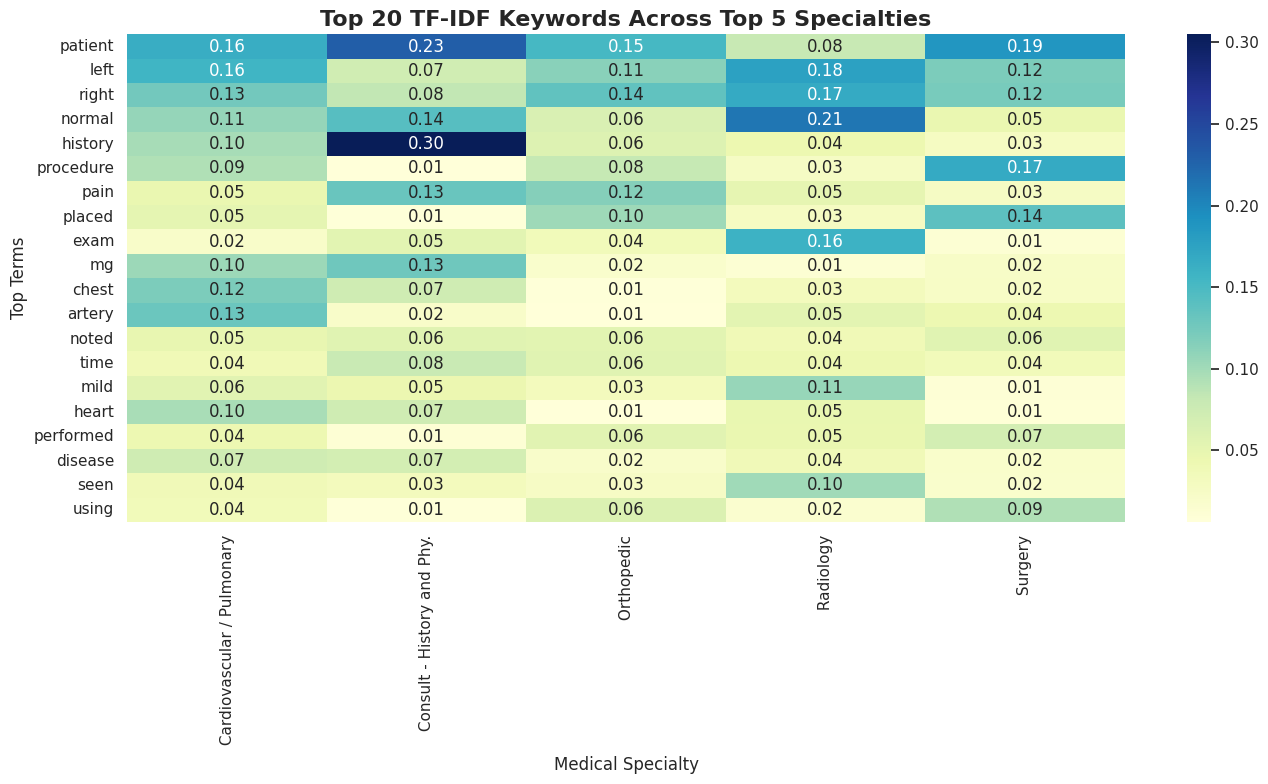

In [ ]:
top_5_specialties = df['medical_specialty'].value_counts().head(5).index.tolist()
subset = df[df['medical_specialty'].isin(top_5_specialties)]

# Vectorize with TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_tfidf = vectorizer.fit_transform(subset['transcription'].astype(str))
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df['specialty'] = subset['medical_specialty'].values

# Group by specialty and take mean TF-IDF score per term
grouped_tfidf = tfidf_df.groupby('specialty').mean().T
top_keywords = grouped_tfidf.mean(axis=1).sort_values(ascending=False).head(20).index
heatmap_data = grouped_tfidf.loc[top_keywords]

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Top 20 TF-IDF Keywords Across Top 5 Specialties", fontsize=16, weight='bold')
plt.xlabel("Medical Specialty")
plt.ylabel("Top Terms")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


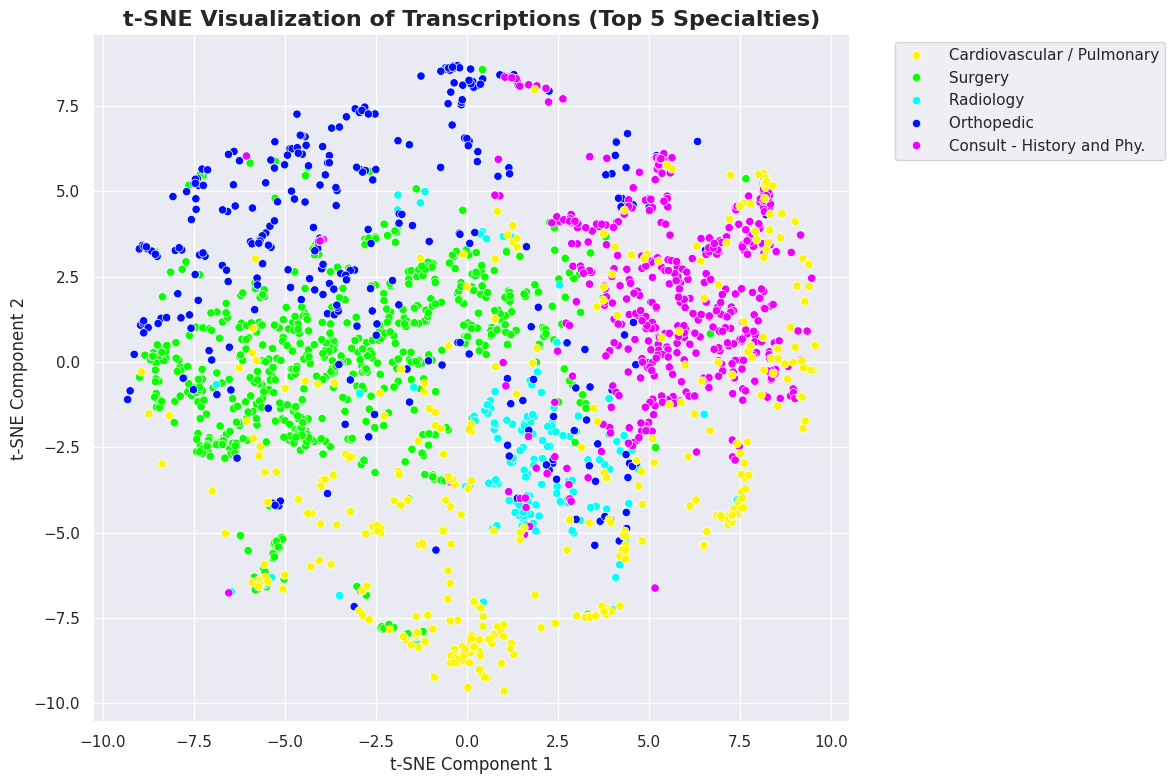

In [ ]:
import numpy as np
X_reduced = PCA(n_components=50).fit_transform(X_tfidf.toarray())
X_tsne = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(X_reduced)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(subset['medical_specialty'])

# Scatter plot
plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", len(np.unique(labels)))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=subset['medical_specialty'], palette=palette, legend='full')
plt.title("t-SNE Visualization of Transcriptions (Top 5 Specialties)", fontsize=16, weight='bold')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
null_summary = df.isnull().sum()

In [ ]:
null_summary

Unnamed: 0                  0
description                 0
medical_specialty           0
sample_name                 0
transcription              33
keywords                 1068
transcript_length_raw       0
transcript_length           0
Word Count                  0
dtype: int64

In [ ]:
df = df.dropna(subset=['transcription'])

# Fill missing keywords with 'None'
df['keywords'] = df['keywords'].fillna('None')

# Confirm that there are no more missing values
final_null_check = df.isnull().sum()

<ipython-input-29-5c6ed38fdb7c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keywords'] = df['keywords'].fillna('None')


In [ ]:
final_null_check

Unnamed: 0               0
description              0
medical_specialty        0
sample_name              0
transcription            0
keywords                 0
transcript_length_raw    0
transcript_length        0
Word Count               0
dtype: int64

In [ ]:
import re
import string

In [ ]:
df = df.dropna(subset=['transcription'])
df['keywords'] = df['keywords'].fillna('None')

In [ ]:
def basic_clean(text):
    text = text.lower()  # lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(r'\s+', ' ', text).strip()  # normalize whitespace
    return text

# Step 3: Apply cleaning function
df['clean_basic'] = df['transcription'].apply(basic_clean)
df['Word Count (Cleaned)'] = df['clean_basic'].apply(lambda x: len(x.split()))

In [ ]:
print(df['clean_basic'].head())
print(df['Word Count (Cleaned)'].head())

0    subjective this yearold white female presents ...
1    past medical history he has difficulty climbin...
2    history of present illness i have seen abc tod...
3    d mmode left atrial enlargement with left atri...
4    the left ventricular cavity size and wall thic...
Name: clean_basic, dtype: object
0    201
1    343
2    691
3     61
4    221
Name: Word Count (Cleaned), dtype: int64


In [ ]:
!pip install spacy

In [ ]:
import spacy
from nltk.corpus import stopwords
import nltk

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 26.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def advanced_clean(text):
    # Basic cleaning
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Lemmatize + remove stopwords
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.is_alpha]
    return ' '.join(tokens)

# Apply cleaning
df['clean_advanced'] = df['transcription'].apply(advanced_clean)
df['Word Count (Advanced)'] = df['clean_advanced'].apply(lambda x: len(x.split()))

<ipython-input-40-862106dd464c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='Word Count (Advanced)', y='medical_specialty', palette="Spectral")


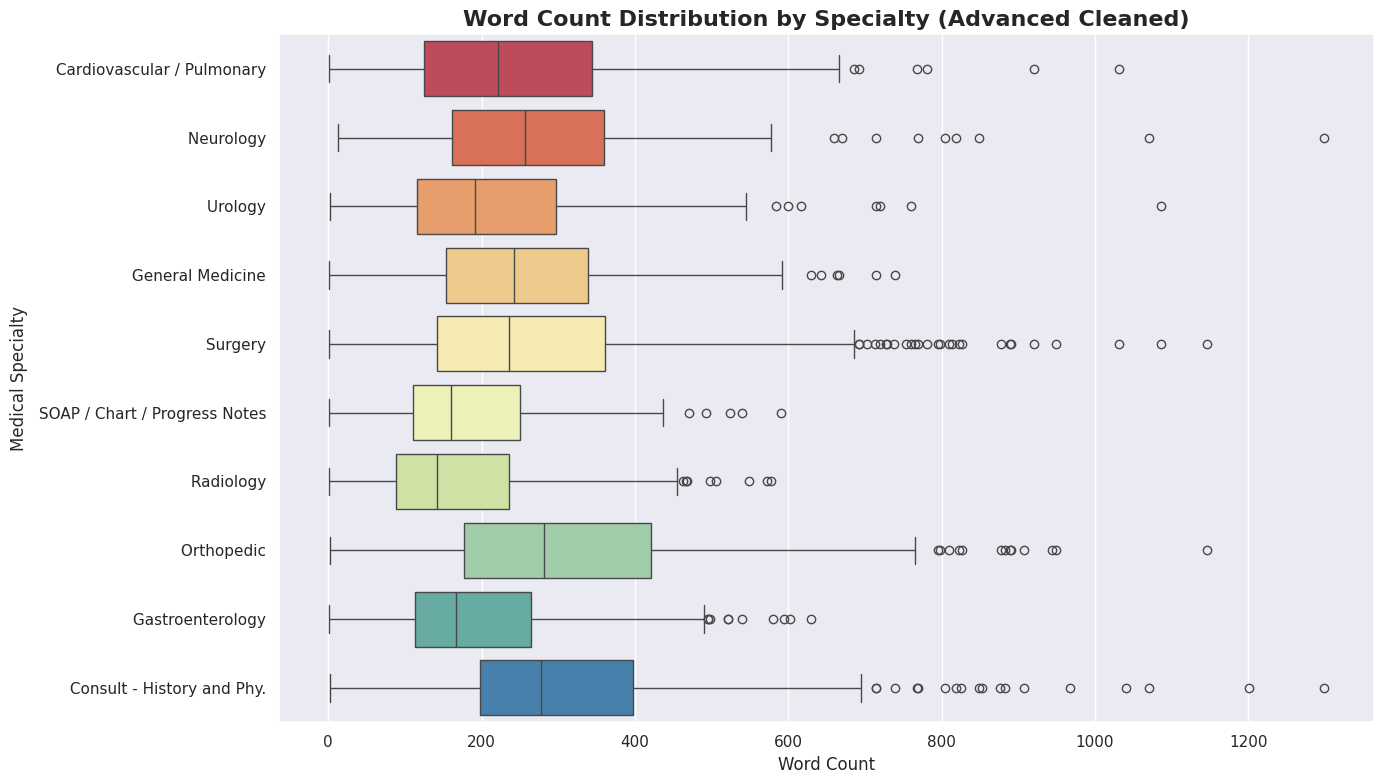

In [ ]:
top_specialties = df['medical_specialty'].value_counts().head(10).index
filtered_df = df[df['medical_specialty'].isin(top_specialties)]
plt.figure(figsize=(14, 8))
sns.boxplot(data=filtered_df, x='Word Count (Advanced)', y='medical_specialty', palette="Spectral")
plt.title("Word Count Distribution by Specialty (Advanced Cleaned)", fontsize=16, weight='bold')
plt.xlabel("Word Count")
plt.ylabel("Medical Specialty")
plt.tight_layout()
plt.show()


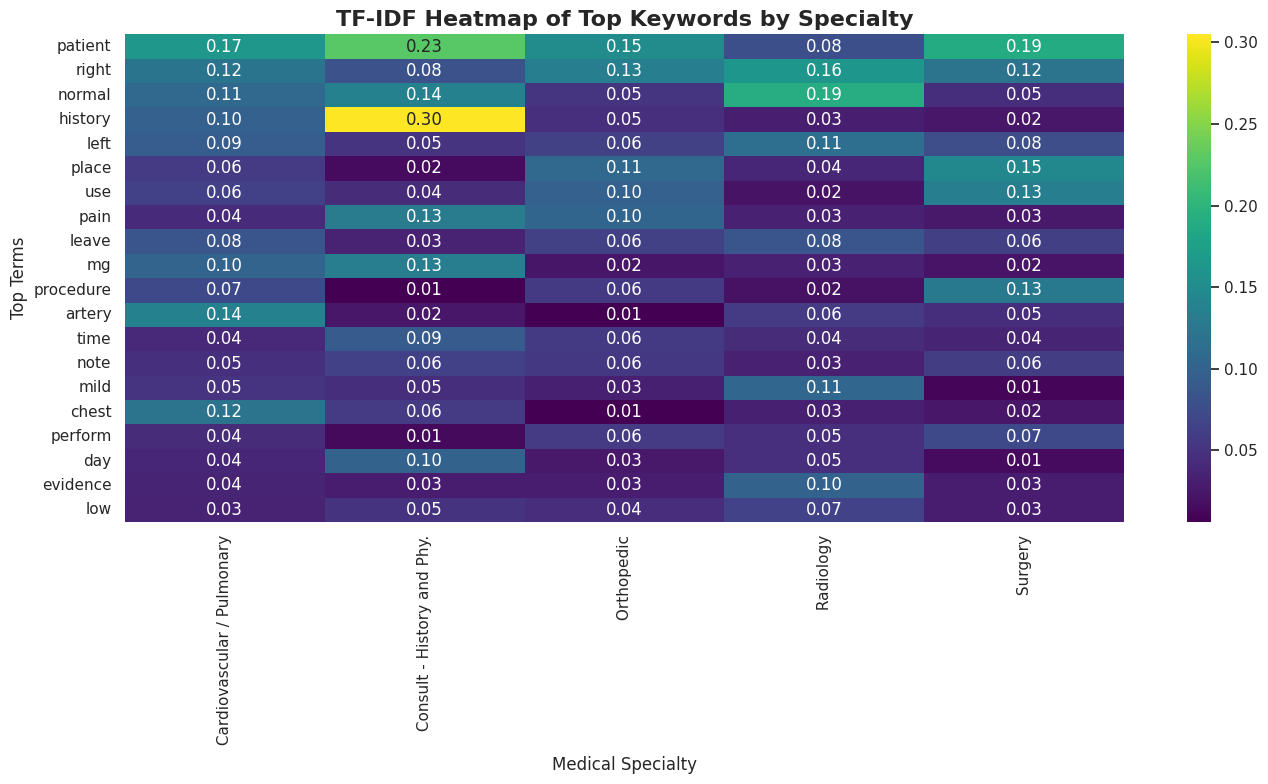

In [ ]:
top_5_specialties = df['medical_specialty'].value_counts().head(5).index.tolist()
subset = df[df['medical_specialty'].isin(top_5_specialties)]
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
X_tfidf = vectorizer.fit_transform(subset['clean_advanced'].astype(str))
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df['specialty'] = subset['medical_specialty'].values
grouped_tfidf = tfidf_df.groupby('specialty').mean().T
top_keywords = grouped_tfidf.mean(axis=1).sort_values(ascending=False).head(20).index
heatmap_data = grouped_tfidf.loc[top_keywords]
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".2f")
plt.title("TF-IDF Heatmap of Top Keywords by Specialty", fontsize=16, weight='bold')
plt.xlabel("Medical Specialty")
plt.ylabel("Top Terms")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


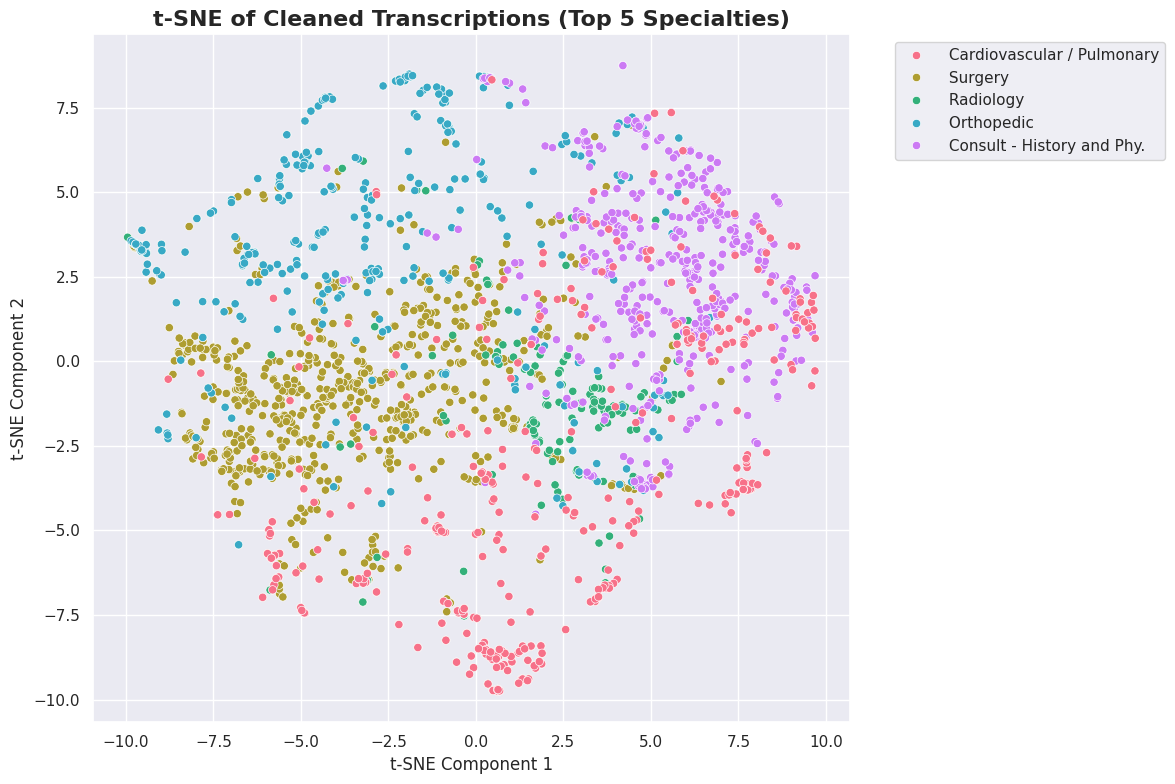

In [ ]:
X_reduced = PCA(n_components=50).fit_transform(X_tfidf.toarray())
X_tsne = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(X_reduced)
le = LabelEncoder()
labels = le.fit_transform(subset['medical_specialty'])
plt.figure(figsize=(12, 8))
palette = sns.color_palette("husl", len(set(labels)))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=subset['medical_specialty'], palette=palette, legend='full')
plt.title("t-SNE of Cleaned Transcriptions (Top 5 Specialties)", fontsize=16, weight='bold')
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

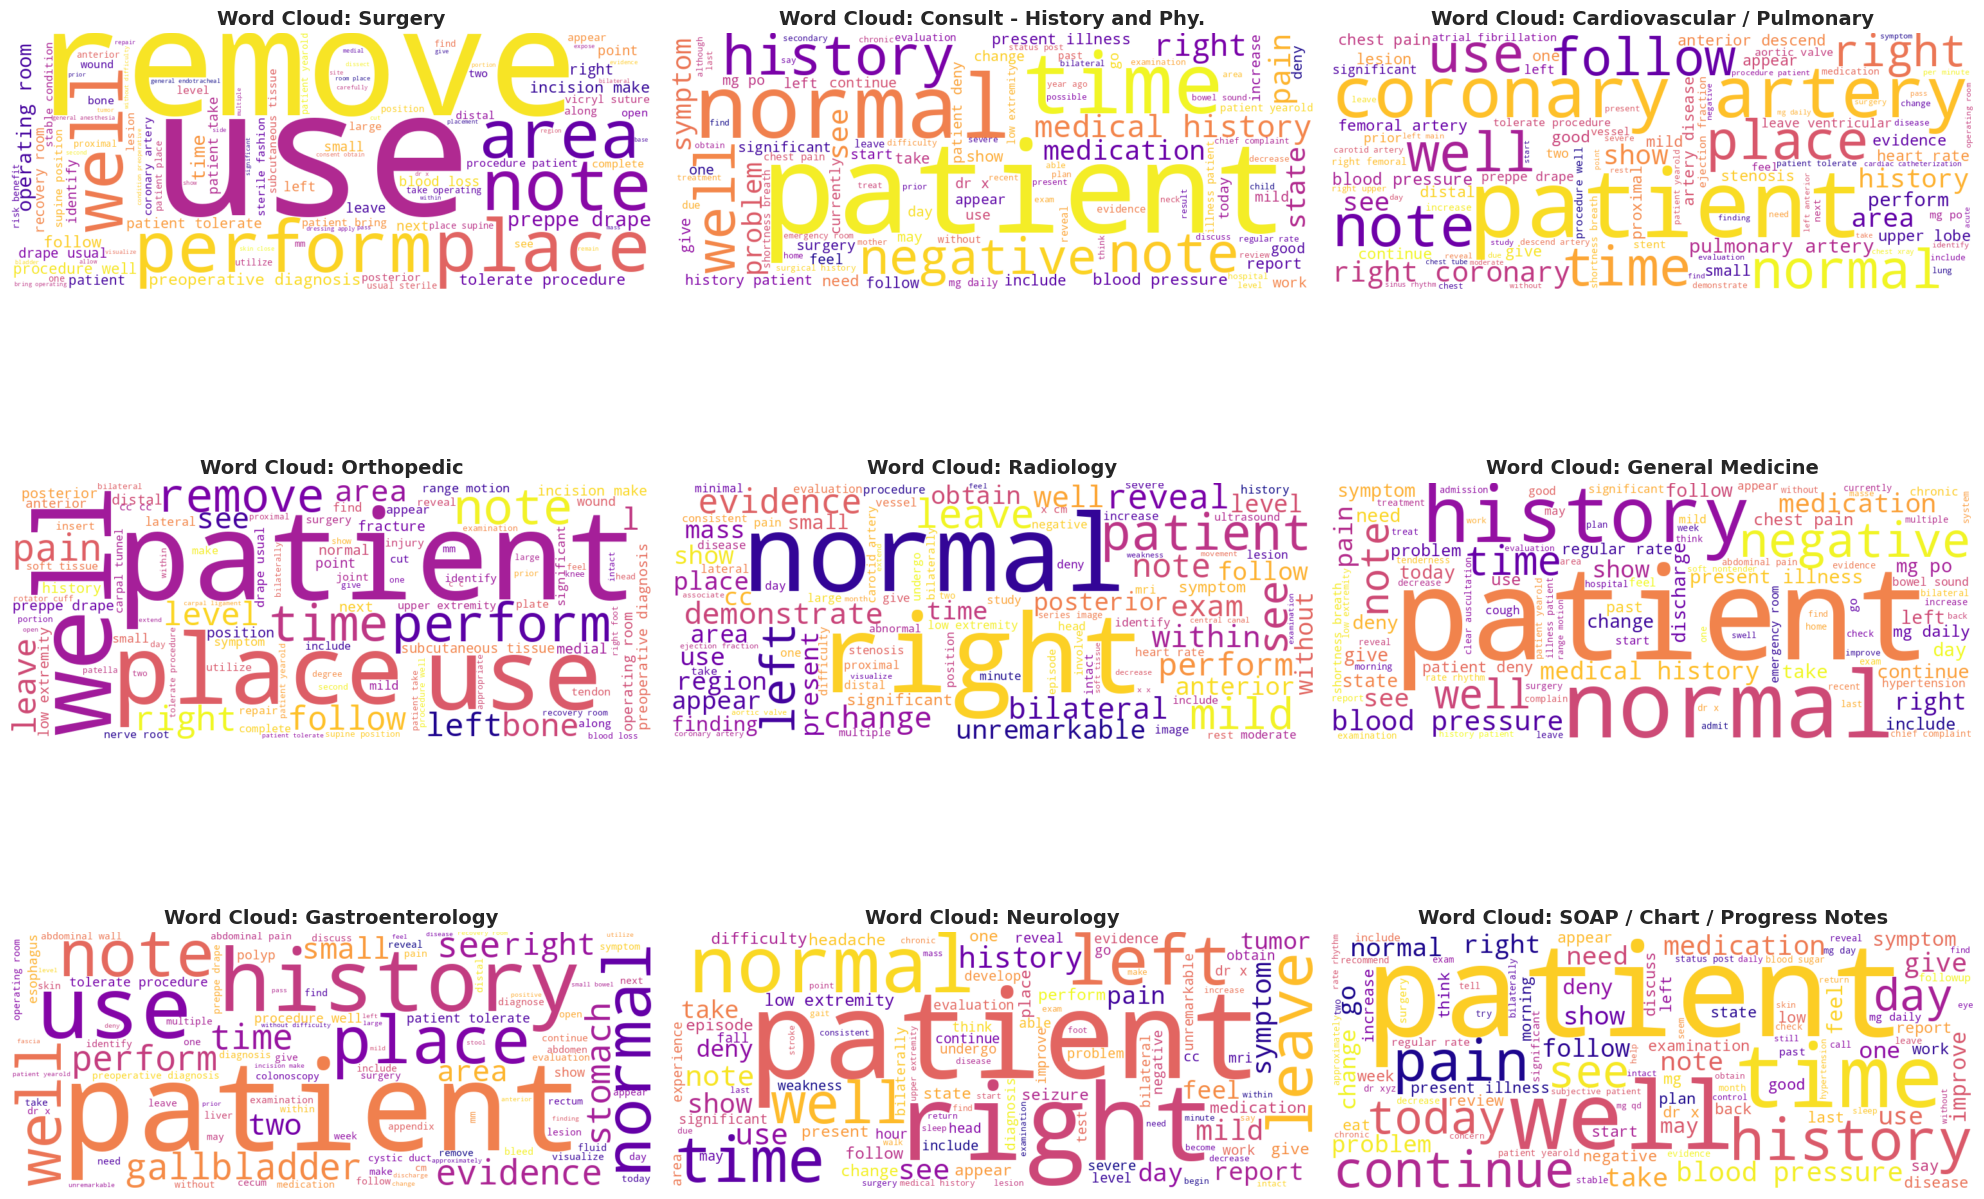

In [ ]:
top_specialties = df['medical_specialty'].value_counts().head(9).index.tolist()

# Plot settings
fig, axes = plt.subplots(3, 3, figsize=(20, 15))  # 3x3 grid for top 9
axes = axes.flatten()

# Generate one word cloud per specialty
for i, specialty in enumerate(top_specialties):
    text = " ".join(df[df['medical_specialty'] == specialty]['clean_advanced'].astype(str).tolist())
    wc = WordCloud(width=1000, height=400, background_color='white',
                   colormap='plasma', max_words=100).generate(text)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].set_title(f"Word Cloud: {specialty.strip()}", fontsize=14, weight='bold')
    axes[i].axis('off')

# Hide unused subplots if fewer than 9
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

<ipython-input-44-b434ca9a5498>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frequencies), y=list(ngram_phrases), palette='crest')


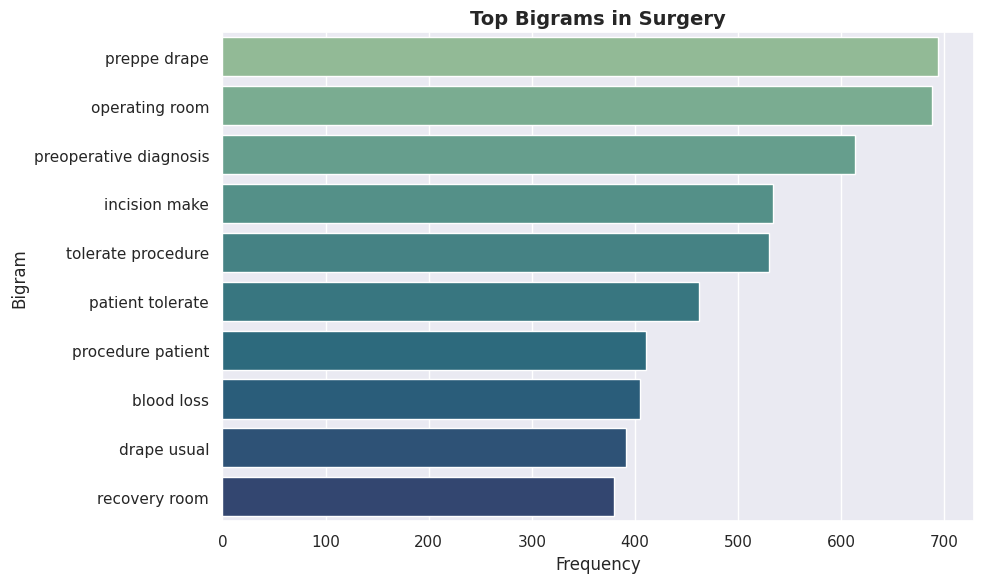

<ipython-input-44-b434ca9a5498>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frequencies), y=list(ngram_phrases), palette='crest')


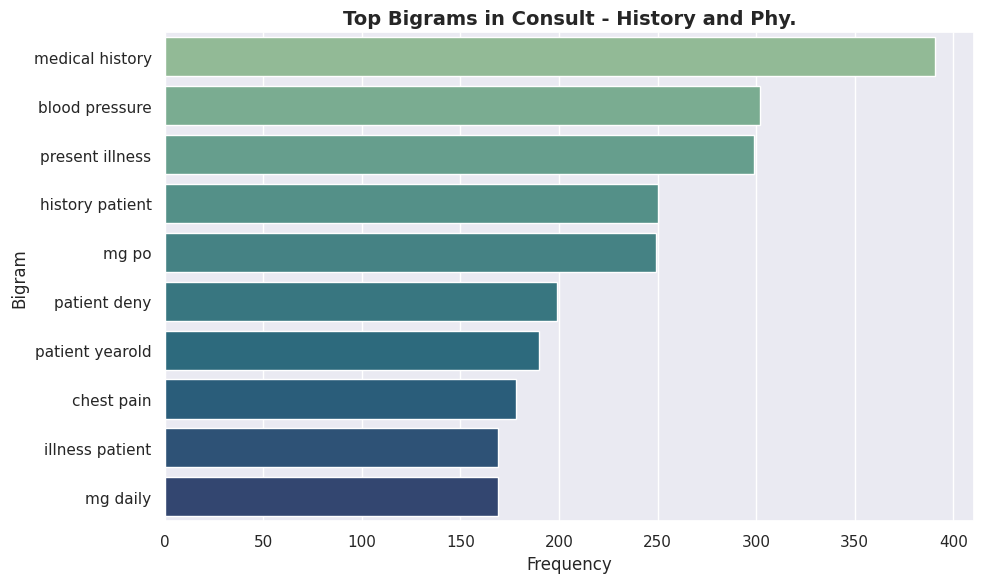

<ipython-input-44-b434ca9a5498>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frequencies), y=list(ngram_phrases), palette='crest')


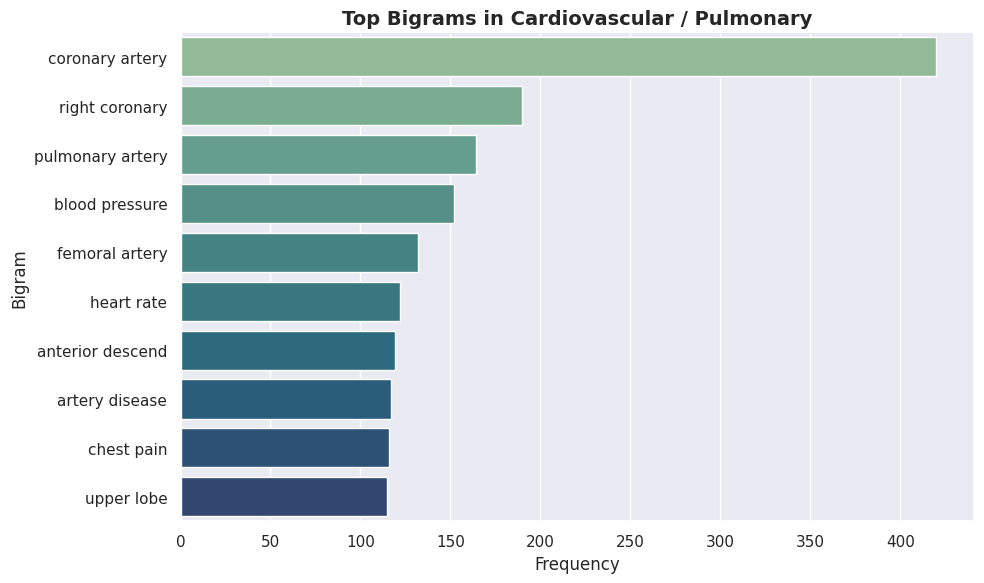

<ipython-input-44-b434ca9a5498>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frequencies), y=list(ngram_phrases), palette='crest')


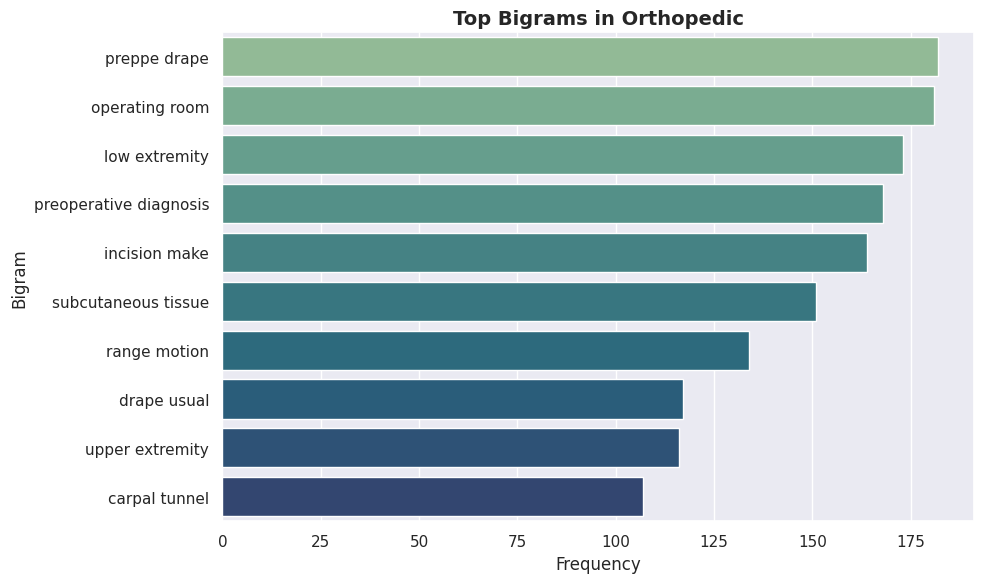

<ipython-input-44-b434ca9a5498>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frequencies), y=list(ngram_phrases), palette='crest')


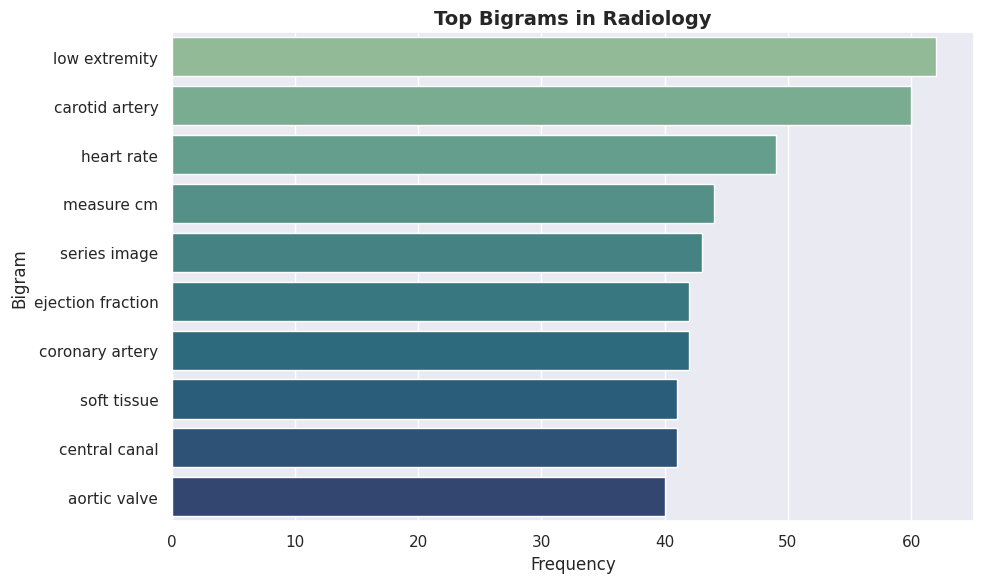

In [ ]:
top_specialties = df['medical_specialty'].value_counts().head(5).index.tolist()
df_top = df[df['medical_specialty'].isin(top_specialties)]

# Function to generate top N n-grams from a corpus
def get_top_ngrams(corpus, ngram_range=(2, 2), n=10):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Plot N-grams per specialty
for specialty in top_specialties:
    text = df_top[df_top['medical_specialty'] == specialty]['clean_advanced'].astype(str)
    top_ngrams = get_top_ngrams(text, ngram_range=(2, 2), n=10)  # Change (2,2) to (3,3) for trigrams

    # Unpack data
    ngram_phrases, frequencies = zip(*top_ngrams)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(frequencies), y=list(ngram_phrases), palette='crest')
    plt.title(f"Top Bigrams in {specialty.strip()}", fontsize=14, weight='bold')
    plt.xlabel("Frequency")
    plt.ylabel("Bigram")
    plt.tight_layout()
    plt.show()

<ipython-input-45-981a93d23ea6>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(phrases), palette="flare")


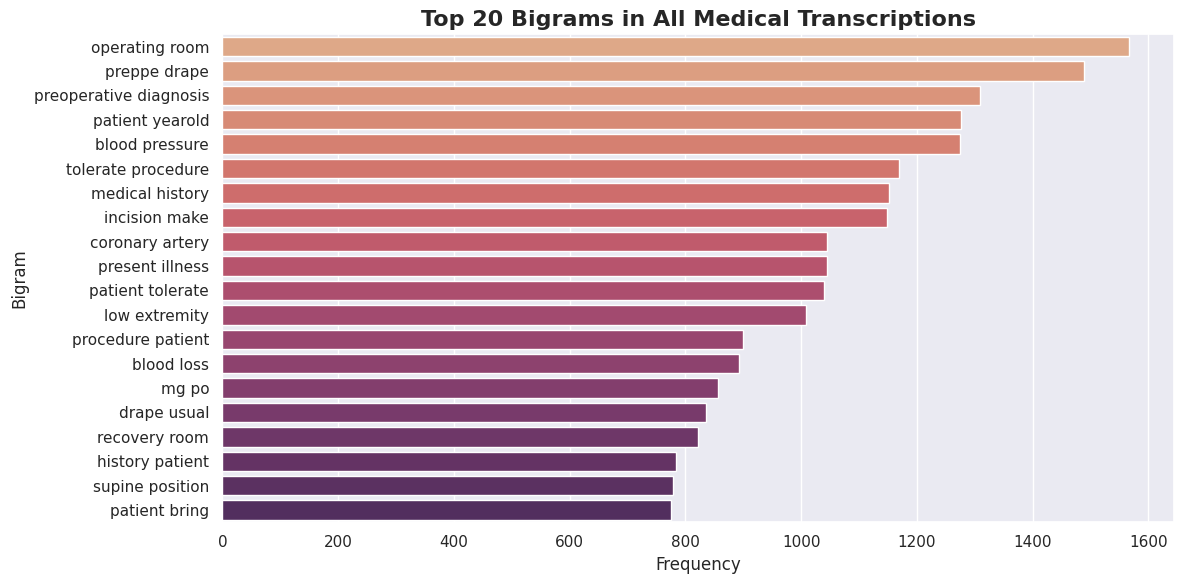

In [ ]:
corpus = df['clean_advanced'].astype(str).tolist()
def get_top_ngrams(corpus, ngram_range=(2, 2), top_n=20):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# Extract top 20 bigrams
top_bigrams = get_top_ngrams(corpus, ngram_range=(2, 2), top_n=20)

# Unpack for plotting
phrases, freqs = zip(*top_bigrams)

# Plot bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x=list(freqs), y=list(phrases), palette="flare")
plt.title("Top 20 Bigrams in All Medical Transcriptions", fontsize=16, weight='bold')
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.tight_layout()
plt.show()

In [ ]:
df = df.dropna(subset=['clean_basic'])

In [ ]:
def remove_personal_entities(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.ent_type_ not in ['PERSON', 'GPE', 'ORG']])

# 6. Apply the NER de-identification function to the cleaned text
df['clean_ner'] = df['clean_basic'].apply(remove_personal_entities)

# 7. Preview original vs de-identified text for verification
print("Original Text:\n", df['clean_basic'].iloc[0])
print("\nDe-identified Text:\n", df['clean_ner'].iloc[0])

Original Text:
 subjective this yearold white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seemed to lose effectiveness she has used allegra also she used that last summer and she began using it again two weeks ago it does not appear to be working very well she has used overthecounter sprays but no prescription nasal sprays she does have asthma but doest not require daily medication for this and does not think it is flaring upmedications her only medication currently is ortho tricyclen and the allegraallergies she has no known medicine allergiesobjectivevitals weight was pounds and blood pressure heent her throat was mildly erythematous without exudate nasal mucosa was erythematous and swollen only clear drainage was seen tms were clearneck supple without adenopathylungs clearassessment allergic rhinitisplan she will tr

In [ ]:
# Tokenize clean_basic text
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_basic'])
sequences = tokenizer.texts_to_sequences(df['clean_basic'])
padded_sequences = pad_sequences(sequences, maxlen=512, padding='post', truncating='post')

In [ ]:
!pip install transformers datasets

In [ ]:
from datasets import Dataset
# Encode labels
if 'label' not in df.columns:
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['medical_specialty'])

# Prepare DataFrame for Hugging Face
df_hf = df[['clean_ner', 'label']].rename(columns={'clean_ner': 'text'})

# Stratified split
train_df, val_df = train_test_split(df_hf, test_size=0.2, stratify=df_hf['label'], random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)


In [ ]:
# Load BioBERT tokenizer
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

# Data collator for batching
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Convert to TensorFlow datasets
tf_train = tokenized_train.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_val = tokenized_val.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols=["label"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/3972 [00:00<?, ? examples/s]

Map:   0%|          | 0/994 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
from transformers import TFAutoModelForSequenceClassification

# Load BioBERT TensorFlow model
num_labels = df['label'].nunique()
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, from_pt=True)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

# Train the model
model.fit(tf_train, validation_data=tf_val, epochs=3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


In [ ]:
# Evaluate and predict
preds = model.predict(tf_val)
y_pred = tf.argmax(preds.logits, axis=1).numpy()
y_true = val_dataset['label']

from sklearn.metrics import classification_report, accuracy_score

# Print validation results
print(f"Validation Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))